Test Accuracy: 93.75%
output 0: [tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, devic

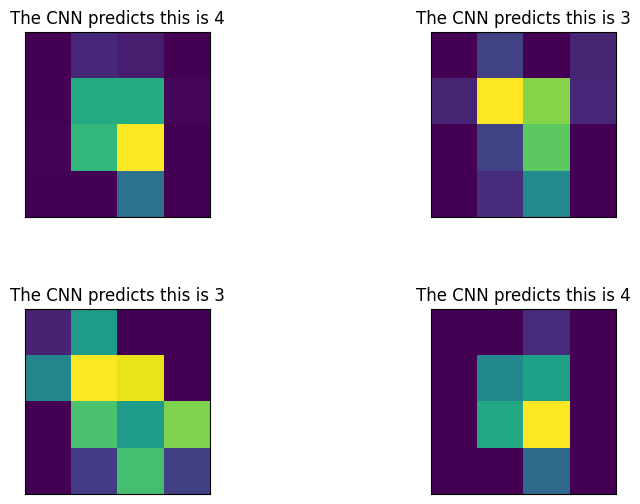

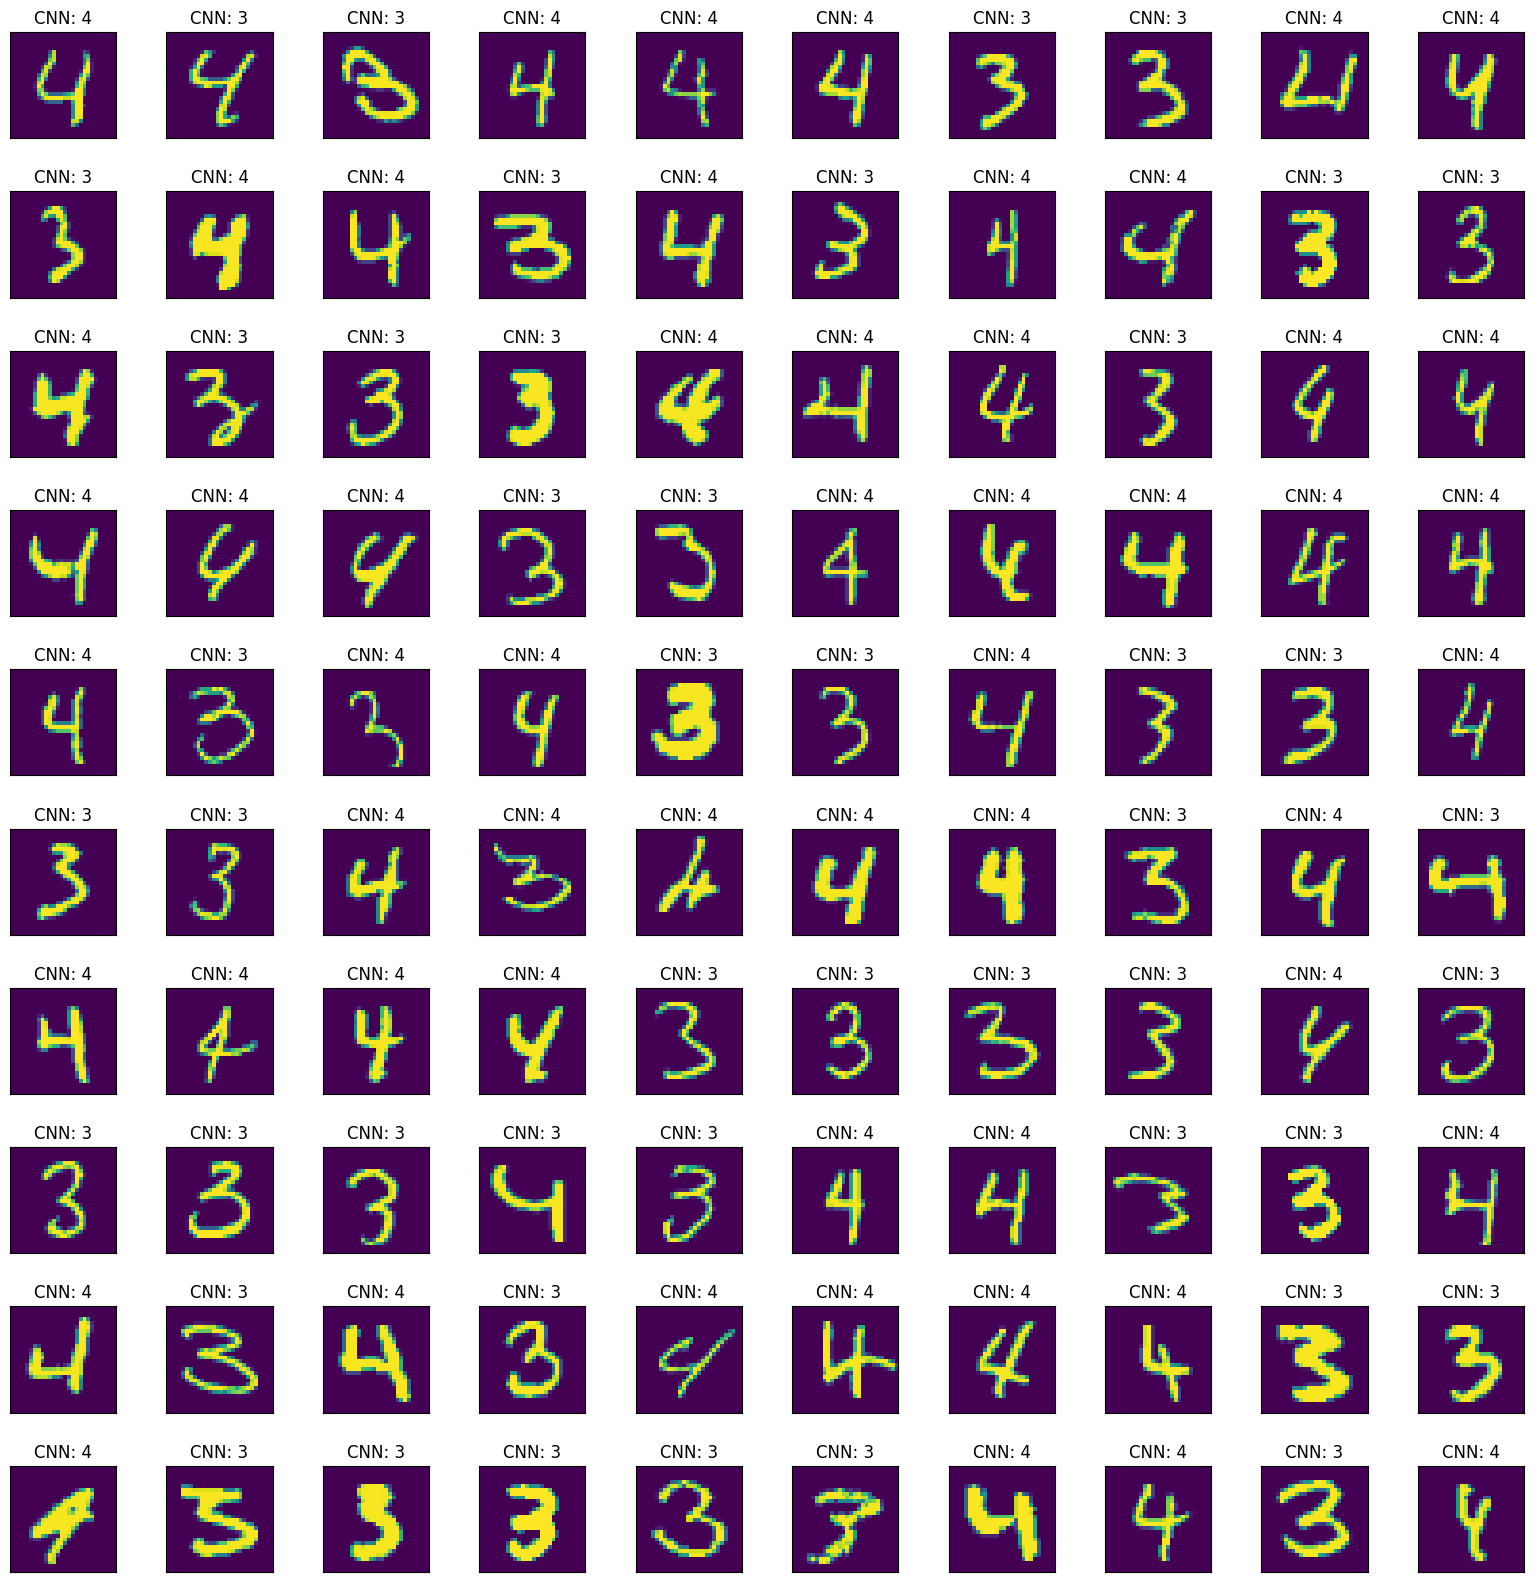

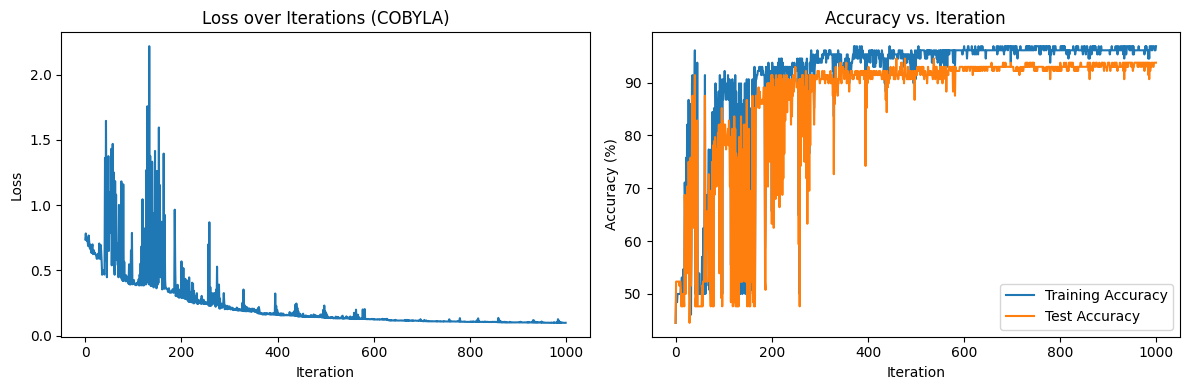

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F

# Creating/Formatting Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

# Filter Values
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
    return y_temp

x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:128]
y = y[0:128]
x1 = x1[0:128]
y1 = y1[0:128]
print(x)
print(y)

# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda").reshape(-1, 1, 4, 4)
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda").reshape(-1, 1, 4, 4)
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

# One-Hot Encoding for Final Processing
num_classes = 2

print(X.shape,Y.shape,X1.shape,Y1.shape)

# Simplified CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4 * 2 * 2, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 4 * 2 * 2)
        x = self.fc1(x)
        return x

# Create an instance of the model
model = SimpleCNN().to("cuda")

# One-Hot Encoding for Pytorch
Y = F.one_hot(Y, num_classes).float()
Y1 = F.one_hot(Y1, num_classes).float()

# Loss Function (Categorical Cross Entropy)
loss_function = nn.CrossEntropyLoss()

# Callback Helper Functions
def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

# Create copies of data to shuffle in between iterations
X_cobyla=X.clone().detach()
Y_cobyla=Y.clone().detach()
# Global Iteration Counter and Data Storage
i = 1
data = []
loss_list = []
train_accuracy_list = []
test_accuracy_list = []

def objective_function(weights, model_class=SimpleCNN, num_classes=num_classes, X=X_cobyla, Y=Y_cobyla, X1=X1, Y1=Y1):
    global i
    global loss_list
    global train_accuracy_list
    global test_accuracy_list
    
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
    
    # Reshape the weights to match the model's parameters
    weights_reshaped = reshape_weights(weights, model_class, num_classes)

    # Create a new instance of the model with the given weights
    model = model_class(num_classes=num_classes).to("cuda")
    
    # Set the model's parameters to the reshaped weights
    model.load_state_dict(weights_reshaped)

    # Calculate the output of the model on training data
    output = model(X)

    # Calculate the loss
    loss = loss_function(output, Y)
    print("Loss:", loss.item())
    loss_list.append(loss.item())

    # Calculate and store training accuracy
    train_acc = accuracy(output, Y)
    train_accuracy_list.append(train_acc)
    
    # Calculate and store test accuracy
    output1 = model(X1)
    test_acc = accuracy(output1,Y1)
    test_accuracy_list.append(test_acc)

    print(f"Iteration: {i}; Training Accuracy: {train_acc}%; Test Accuracy: {test_acc}%")

    return loss.item()

def reshape_weights(weights, model_class, num_classes):
    model = model_class(num_classes=num_classes)
    state_dict = model.state_dict()
    start_idx = 0

    for name, param in state_dict.items():
        num_params = param.numel()
        param_shape = param.shape
        state_dict[name] = torch.from_numpy(weights[start_idx:start_idx + num_params]).view(param_shape).float()
        start_idx += num_params

    return state_dict

def callback(weights, model_class=SimpleCNN, num_classes=num_classes):
    global i
    global data
    global loss_list
    global train_accuracy_list
    global test_accuracy_list

    # Reshape the weights for printing
    weights_reshaped = reshape_weights(weights, model_class, num_classes)

    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))

    # Plotting Loss Function
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    
    # Plotting Training and Test Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_accuracy_list)), train_accuracy_list, label='Training Accuracy')
    plt.plot(range(len(test_accuracy_list)), test_accuracy_list, label='Test Accuracy')
    plt.title("Accuracy vs. Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Printing Weights
    print("Current weights (reshaped):")
    for name, param in weights_reshaped.items():
        print(f"{name}: {param.detach().cpu().numpy()}")

    # Iteration Counter
    i += 1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

def get_initial_weights(model_class, num_classes):
    model = model_class(num_classes=num_classes)
    weights = []
    for param in model.parameters():
        weights.extend(param.detach().cpu().numpy().flatten())
    return np.array(weights)

# Get initial weights
initial_weights = get_initial_weights(SimpleCNN, num_classes)

# COBYLA Optimization
result = minimize(
    fun=objective_function,
    x0=initial_weights,
    method='COBYLA',
    callback=callback,
    options={'maxiter': 1000, 'rhobeg': 1.0, 'disp': True}
)

# Extract and reshape the final weights
final_weights = result.x
final_weights_reshaped = reshape_weights(final_weights, SimpleCNN, num_classes)

# Load the final weights into the model
model = SimpleCNN(num_classes=num_classes).to("cuda")
model.load_state_dict(final_weights_reshaped)

# Evaluate on Test Data
model.eval()
with torch.no_grad():
    output0 = model(X)
    output1 = model(X1)
    test_acc = accuracy(output1, Y1)
    print(f"Test Accuracy: {test_acc:.2f}%")

# Save the Model
torch.save(model.state_dict(), "cnn_model_cobyla128.pth")

# Analyze Predictions
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr

print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

# Visualize Predictions on Resized Test Images
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    pred = torch.argmax(output1[i])
    ax[i // 2, i % 2].set_title(f"The CNN predicts this is {a if pred == 0 else b}")
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

# Visualize Predictions on Original Test Images
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")
      pred = torch.argmax(output1[i])
      ax[row, col].set_title(f"CNN: {a if pred == 0 else b}")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

# Plotting Loss and Accuracy from COBYLA optimization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Loss over Iterations (COBYLA)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracy_list)), train_accuracy_list, label='Training Accuracy')
plt.plot(range(len(test_accuracy_list)), test_accuracy_list, label='Test Accuracy')
plt.title("Accuracy vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
print(train_accuracy_list[333],train_accuracy_list[666], train_accuracy_list[999])
print(test_accuracy_list[333],test_accuracy_list[666], test_accuracy_list[999])

92.96875 96.09375 96.875
92.96875 92.96875 93.75
